In [1]:
import os, random, math, json, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models, optimizers, callbacks

from konlpy.tag import Mecab
from collections import Counter
from itertools import chain

from gensim.models.keyedvectors import Word2VecKeyedVectors

print("TF   :", tf.__version__)
print("GPU devices visible:", tf.config.list_physical_devices('GPU'))

import pandas as pandas_lib
import konlpy as konlpy_lib
import gensim as gensim_lib
print("pandas:", pandas_lib.__version__)
print("konlpy:", konlpy_lib.__version__)
print("gensim:", gensim_lib.__version__)

SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for g in gpus:
            tf.config.experimental.set_memory_growth(g, True)
    except Exception:
        pass

2025-08-01 17:30:45.574650: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-01 17:30:45.591721: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-01 17:30:45.591746: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-01 17:30:45.592213: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-01 17:30:45.595651: I tensorflow/core/platform/cpu_feature_guar

TF   : 2.15.1
GPU devices visible: []
pandas: 2.3.1
konlpy: 0.6.0
gensim: 4.3.2


2025-08-01 17:30:46.651647: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-01 17:30:46.664838: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [2]:
train_path = './data/ratings_train.txt'
test_path  = './data/ratings_test.txt'

train_df = pd.read_table(train_path)
test_df = pd.read_table(test_path)

train_df = train_df.drop_duplicates(subset=['document']).dropna(how='any').reset_index(drop=True)
test_df  = test_df.drop_duplicates(subset=['document']).dropna(how='any').reset_index(drop=True)

print(train_df.shape, test_df.shape)
train_df.head()

(146182, 3) (49157, 3)


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [3]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab(dicpath="/usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ko-dic")
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [4]:
def tokenize(sent):
    toks = tokenizer.morphs(sent)
    toks = [t for t in toks if t not in stopwords]
    return toks

X_train_tokens = [tokenize(s) for s in train_df['document']]
X_test_tokens  = [tokenize(s) for s in test_df['document']]
y_train = train_df['label'].astype(int).values
y_test  = test_df['label'].astype(int).values

In [5]:
special_tokens = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>']

# 빈도수 상위 num_words-4 사용
num_words = 10000
all_words = list(chain.from_iterable(X_train_tokens))
counter = Counter(all_words).most_common(num_words - len(special_tokens))
vocab = special_tokens + [w for w, _ in counter]

word_to_index = {w:i for i, w in enumerate(vocab)}
index_to_word = {i:w for w,i in word_to_index.items()}

def words_to_indices(tokens):
    return [word_to_index.get(t, word_to_index['<UNK>']) for t in tokens]

X_train_ids = [[word_to_index['<BOS>']] + words_to_indices(ts) for ts in X_train_tokens]
X_test_ids  = [[word_to_index['<BOS>']] + words_to_indices(ts)  for ts in X_test_tokens]

vocab_size = len(vocab)
print("Vocab size:", vocab_size)

Vocab size: 10000


문장 길이 통계 — min:1, max:117, mean:17.0, 95%:48, 99%:62


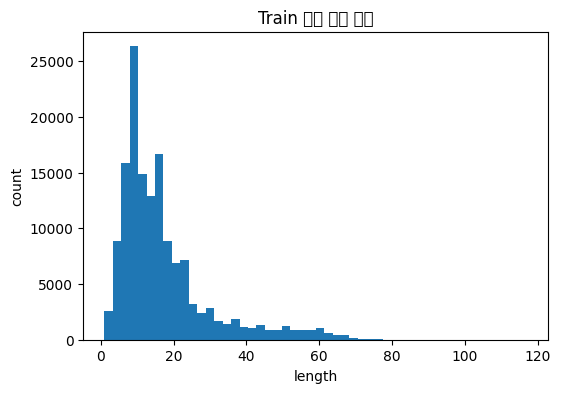

선정된 MAX_LEN: 48


In [6]:
lengths = np.array([len(x) for x in X_train_ids])
print("문장 길이 통계 — min:{}, max:{}, mean:{:.1f}, 95%:{:.0f}, 99%:{:.0f}".format(
    lengths.min(), lengths.max(), lengths.mean(), np.percentile(lengths,95), np.percentile(lengths,99)
))

# 히스토그램(분포)
plt.figure(figsize=(6,4))
plt.hist(lengths, bins=50)
plt.title("Train 문장 길이 분포")
plt.xlabel("length"); plt.ylabel("count")
plt.show()


MAX_LEN = int(np.percentile(lengths, 95))
MAX_LEN = max(20, min(MAX_LEN, 200))  # 안전한 범위로 클리핑
print("선정된 MAX_LEN:", MAX_LEN)

In [7]:
X_train_pad = pad_sequences(X_train_ids, maxlen=MAX_LEN, padding='post', truncating='post', value=word_to_index['<PAD>'])
X_test_pad  = pad_sequences(X_test_ids,  maxlen=MAX_LEN, padding='post', truncating='post', value=word_to_index['<PAD>'])

In [8]:
def build_fasttext_like(vocab_size, embed_dim=128, maxlen=MAX_LEN):
    inp = layers.Input(shape=(maxlen,))
    x = layers.Embedding(vocab_size, embed_dim, mask_zero=True, name="emb")(inp)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    m = models.Model(inp, out, name="FastTextLike")
    m.compile(optimizer=optimizers.Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])
    return m

def build_cnn(vocab_size, embed_dim=128, maxlen=MAX_LEN):
    inp = layers.Input(shape=(maxlen,))
    x = layers.Embedding(vocab_size, embed_dim, mask_zero=True, name="emb")(inp)
    x = layers.Conv1D(128, 3, padding='same', activation='relu')(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    m = models.Model(inp, out, name="TextCNN")
    m.compile(optimizer=optimizers.Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])
    return m

def build_bilstm(vocab_size, embed_dim=128, maxlen=MAX_LEN):
    inp = layers.Input(shape=(maxlen,))
    x = layers.Embedding(vocab_size, embed_dim, mask_zero=True, name="emb")(inp)
    x = layers.Bidirectional(layers.LSTM(64))(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    m = models.Model(inp, out, name="BiLSTM")
    m.compile(optimizer=optimizers.Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])
    return m


In [9]:
from gensim.models import Word2Vec
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_file_path = './data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
kv = word_vectors.wv

w2v_dim = kv.vector_size
print(f"Loaded embeddings: {word2vec_file_path}, dim: {w2v_dim}")

Loaded embeddings: ./data/word2vec_ko.model, dim: 100


In [10]:
embedding_matrix = np.random.normal(loc=0.0, scale=0.05, size=(vocab_size, w2v_dim)).astype(np.float32)
embedding_matrix[word_to_index['<PAD>']] = 0.0  # PAD는 0 벡터

hit = 0
for w, idx in word_to_index.items():
    if w in special_tokens:
        continue

    if kv.has_index_for(w):
        embedding_matrix[idx] = kv[w]
        hit += 1

print(f"Pretrained coverage: {hit}/{vocab_size} ({100*hit/vocab_size:.1f}%)")

Pretrained coverage: 9457/10000 (94.6%)


In [11]:
# --- 사전학습 임베딩 주입 BiLSTM (freeze/finetune용) ---
def build_bilstm_pretrained(vocab_size, embedding_matrix, maxlen=MAX_LEN, trainable=False):
    inp = layers.Input(shape=(maxlen,))
    x = layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_matrix.shape[1],  # w2v_dim
        weights=[embedding_matrix],
        trainable=trainable,
        mask_zero=True,
        name="emb_pre"
    )(inp)
    x = layers.Bidirectional(layers.LSTM(64))(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    m = models.Model(inp, out, name=f"BiLSTM_W2V_trainable_{trainable}")
    m.compile(optimizer=optimizers.Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])
    return m


In [12]:
BATCH = 128
EPOCHS = 15
es = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

def train_and_eval(model, name):
    h = model.fit(X_train_pad, y_train, validation_split=0.2,
                  epochs=EPOCHS, batch_size=BATCH, callbacks=[es], verbose=1)
    loss, acc = model.evaluate(X_test_pad, y_test, batch_size=BATCH, verbose=0)
    print(f"[{name}] Test Acc: {acc*100:.2f}%")
    return h, (loss, acc)

# 베이스라인 3종
m_ft = build_fasttext_like(vocab_size, embed_dim=128, maxlen=MAX_LEN)
h_ft, s_ft = train_and_eval(m_ft, "FastTextLike")

m_cnn  = build_cnn(vocab_size, embed_dim=128, maxlen=MAX_LEN)
h_cnn, s_cnn = train_and_eval(m_cnn, "TextCNN")

m_bi   = build_bilstm(vocab_size, embed_dim=128, maxlen=MAX_LEN)
h_bi, s_bi = train_and_eval(m_bi, "BiLSTM")

# W2V사용 (freeze → finetune)
m_w2v_frozen = build_bilstm_pretrained(vocab_size, embedding_matrix, trainable=False)
h_w2v_frozen, s_w2v_frozen = train_and_eval(m_w2v_frozen, "BiLSTM_W2V_Frozen")

m_w2v_ft = build_bilstm_pretrained(vocab_size, embedding_matrix, trainable=True)

# 파인튜닝은 보통 더 낮은 lr가 안정적
m_w2v_ft.compile(optimizer=optimizers.Adam(5e-4), loss='binary_crossentropy', metrics=['accuracy'])
h_w2v_ft, s_w2v_ft = train_and_eval(m_w2v_ft, "BiLSTM_W2V_FineTune")

Epoch 1/15
914/914 [==============================] - 5s 5ms/step - loss: 0.4002 - accuracy: 0.8253 - val_loss: 0.3534 - val_accuracy: 0.8449
Epoch 2/15
914/914 [==============================] - 4s 5ms/step - loss: 0.3276 - accuracy: 0.8585 - val_loss: 0.3534 - val_accuracy: 0.8453
Epoch 3/15
914/914 [==============================] - 4s 5ms/step - loss: 0.3076 - accuracy: 0.8638 - val_loss: 0.3680 - val_accuracy: 0.8431
Epoch 4/15
914/914 [==============================] - 5s 5ms/step - loss: 0.2954 - accuracy: 0.8679 - val_loss: 0.3728 - val_accuracy: 0.8440
[FastTextLike] Test Acc: 84.42%
Epoch 1/15
914/914 [==============================] - 7s 8ms/step - loss: 0.3771 - accuracy: 0.8300 - val_loss: 0.3235 - val_accuracy: 0.8589
Epoch 2/15
914/914 [==============================] - 7s 8ms/step - loss: 0.2614 - accuracy: 0.8935 - val_loss: 0.3188 - val_accuracy: 0.8662
Epoch 3/15
914/914 [==============================] - 7s 8ms/step - loss: 0.1784 - accuracy: 0.9325 - val_loss: 0.34

- [FastTextLike] Test Acc: 84.42%
- [TextCNN] Test Acc: 86.45%
- [BiLSTM] Test Acc: 85.93%
- [BiLSTM_W2V_Frozen] Test Acc: 83.70%
- [BiLSTM_W2V_FineTune] Test Acc: 85.75%

In [13]:
import numpy as np
from gensim.models import KeyedVectors

def keras_embedding_to_kv(model, layer_name, index_to_word, special_tokens={'<PAD>','<BOS>','<UNK>','<UNUSED>'}):
    """Keras Embedding 레이어 가중치를 gensim KeyedVectors로 변환."""
    W = model.get_layer(layer_name).get_weights()[0]   # (vocab_size, emb_dim)
    kv_emb = KeyedVectors(vector_size=W.shape[1])
    words, vecs = [], []
    # index_to_word: {index: token}
    for idx in range(len(index_to_word)):
        tok = index_to_word[idx]
        if tok in special_tokens:
            continue
        words.append(tok)
        vecs.append(W[idx])
    kv_emb.add_vectors(words, np.asarray(vecs))
    return kv_emb


# 베이스라인 임베딩
kv_ft   = keras_embedding_to_kv(m_ft,  'emb',     index_to_word)   # FastText-like
kv_bi   = keras_embedding_to_kv(m_bi,  'emb',     index_to_word)   # BiLSTM (rand init)

# 사전학습 주입 모델의 임베딩 (동일 토큰 공간)
kv_w2v_frozen = keras_embedding_to_kv(m_w2v_frozen, 'emb_pre', index_to_word)
kv_w2v_ft     = keras_embedding_to_kv(m_w2v_ft,     'emb_pre', index_to_word)

In [15]:
def safe_neighbors(kv_obj, word, topn=10):
    try:
        return kv_obj.most_similar(word, topn=topn)
    except KeyError:
        return []

probe = ['영화','재밌','최고','최악','지루','배우','스토리']
topn = 5

for w in probe:
    print(f"\n=== '{w}' ===")
    for name, kv_obj in [
        ('FastText-like',      kv_ft),
        ('BiLSTM(rand)',       kv_bi),
        ('W2V Frozen',         kv_w2v_frozen),
        ('W2V FineTune',       kv_w2v_ft),
        ('External W2V(orig)', kv),
    ]:
        nbrs = safe_neighbors(kv_obj, w, topn=topn)
        if nbrs:
            pretty = ", ".join([f"{t}:{s:.3f}" for t, s in nbrs])
            print(f"{name:17s} -> {pretty}")
        else:
            print(f"{name:17s} -> (OOV 또는 이웃 없음)")

## W2V Frozen 모델은 가중치를 학습하지 않아서 kv와 값 자체는 동일함


=== '영화' ===
FastText-like     -> 진짜:0.547, 완전:0.543, 이후:0.518, 드라마:0.495, 고:0.493
BiLSTM(rand)      -> 음:0.621, 준다:0.609, 점:0.607, 줍니다:0.600, 스러워:0.574
W2V Frozen        -> 드라마:0.842, 뮤지컬:0.778, 코미디:0.749, 다큐멘터리:0.740, 헐리우드:0.740
W2V FineTune      -> 드라마:0.843, 뮤지컬:0.777, 코미디:0.748, 헐리우드:0.742, 다큐멘터리:0.738
External W2V(orig) -> 드라마:0.842, 뮤지컬:0.778, 코미디:0.749, 다큐멘터리:0.740, 헐리우드:0.740

=== '재밌' ===
FastText-like     -> 수작:0.959, 울컥:0.945, 흠잡:0.944, 이제야:0.943, 완벽:0.941
BiLSTM(rand)      -> 완벽:0.923, 굳:0.919, 천재:0.917, 그리움:0.917, 본받:0.916
W2V Frozen        -> 재미있:0.905, 멋있:0.868, 웃기:0.831, 예쁘:0.809, 슬프:0.775
W2V FineTune      -> 재미있:0.913, 멋있:0.880, 웃기:0.826, 예쁘:0.795, 슬프:0.784
External W2V(orig) -> 재미있:0.905, 멋있:0.868, 웃기:0.831, 예쁘:0.809, 슬프:0.775

=== '최고' ===
FastText-like     -> 수작:0.956, 완벽:0.947, 명작:0.945, 먹먹:0.943, 흥미진진:0.940
BiLSTM(rand)      -> 펑펑:0.915, 이제야:0.893, 고인:0.889, 빠져들:0.888, 유쾌:0.884
W2V Frozen        -> 역대:0.654, 최악:0.610, 최대:0.600, 최저:0.594, 올해:0.579
W2V FineTune  

In [16]:
def has_word(kv_obj, w):
    return kv_obj.has_index_for(w) if hasattr(kv_obj, "has_index_for") else (w in getattr(kv_obj, "key_to_index", {}))

def cos(a, b, eps=1e-8):
    return float(np.dot(a, b) / (np.linalg.norm(a)+eps) / (np.linalg.norm(b)+eps))

print("\n[Drift: External W2V(orig) vs W2V FineTune] (코사인 유사도)")
for w in probe:
    if has_word(kv, w) and has_word(kv_w2v_ft, w):
        print(f"{w:>6s}: {cos(kv[w], kv_w2v_ft[w]):.3f}")
    else:
        print(f"{w:>6s}: (OOV)")

## word 임베딩 부분이 어느정도로 바뀌었는지 코사인 유사도로 측정


[Drift: External W2V(orig) vs W2V FineTune] (코사인 유사도)
    영화: 1.000
    재밌: 0.987
    최고: 0.999
    최악: 0.984
    지루: 0.986
    배우: 1.000
   스토리: 1.000


- KoNLPy, Mecab을 설치하는게 상당히 힘들었다
- 잘 안쓰던 tensorflow를 사용해 중간에 오류 해결하고 수정을 많이 했던 것 같다.
- 사전학습된 word2vec을 사용하는 것과 처음부터 학습하는 것의 모델 성능 차이는 의외로 별로 없다.
- 데이터의 난이도, 모델의 간단한 구조 등의 이유로 성능은 큰 차이가 없는 것 같다.
- 하지만 gensim을 이용해 유사한 단어와 유사도를 확인해보면, 완전히 다른 결과가 나왔다.